# Install the packages using the following commands :

    pip3 install tensorflow    
    pip3 install opencv-python
    pip3 install sklearn scikit-learn auto-sklearn
    pip3 install pygame imutils
    pip3 install numpy matplotlib 
    pip3 install keras

# Import all necessary packages to train the Face Mask Detector Model

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# Initialize the initial learning rate, number of epochs to train and batch size 

   Also allocate the directory of the folder containg the datasets .
   
   grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images

In [2]:
INIT_LR = 1e-4
EPOCHS = 75
BS = 32

DIRECTORY = r"dataset"
CATEGORIES = ["with_mask", "without_mask"]

print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)
        
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

[INFO] loading images...


C:\Users\Reddy\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# construct the training image generator for data augmentation

In [3]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are left off

In [4]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

#construct the head of the model that will be placed on top of the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

#loop over all layers in the base model and freeze them so they will *not* be updated during the first training process

for layer in baseModel.layers:
    layer.trainable = False

# compile our model

In [5]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


C:\Users\Reddy\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# train the head of the network

In [6]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] training head...
Epoch 1/75
184/184 [==============================] - 156s 842ms/step - loss: 0.2362 - accuracy: 0.9195 - val_loss: 0.0860 - val_accuracy: 0.9736
Epoch 2/75
184/184 [==============================] - 148s 804ms/step - loss: 0.0829 - accuracy: 0.9770
Epoch 3/75
184/184 [==============================] - 122s 660ms/step - loss: 0.0690 - accuracy: 0.9809
Epoch 4/75
184/184 [==============================] - 119s 646ms/step - loss: 0.0620 - accuracy: 0.9813
Epoch 5/75
184/184 [==============================] - 125s 677ms/step - loss: 0.0575 - accuracy: 0.9842
Epoch 6/75
184/184 [==============================] - 125s 678ms/step - loss: 0.0540 - accuracy: 0.9860
Epoch 7/75
184/184 [==============================] - 126s 685ms/step - loss: 0.0458 - accuracy: 0.9867
Epoch 8/75
184/184 [==============================] - 124s 673ms/step - loss: 0.0473 - accuracy: 0.9860
Epoch 9/75
184/184 [==============================] - 121s 656ms/step - loss: 0.0439 - accuracy: 0.987

184/184 [==============================] - 108s 586ms/step - loss: 0.0181 - accuracy: 0.9934
[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99       709
without_mask       1.00      0.98      0.99       769

    accuracy                           0.99      1478
   macro avg       0.99      0.99      0.99      1478
weighted avg       0.99      0.99      0.99      1478



# serialize the model to disk

[INFO] saving mask detector model...


C:\Users\Reddy\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


ValueError: x and y must have same first dimension, but have shapes (75,) and (1,)

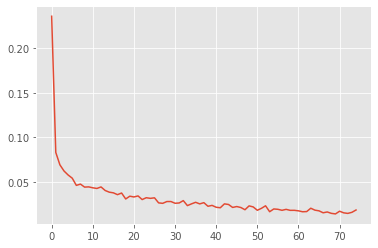

In [7]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")